In [1]:
import keras

from scipy.ndimage.filters import gaussian_filter
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class CombineGradients(Layer):
    def __init__(self, **kwargs):
        super(CombineGradients, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        Gx = inputs[0]
        Gy = inputs[1]
        grad = K.sqrt( Gx**2 + Gy**2 )
        return grad

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [3]:
class Normalize(Layer):
    def __init__(self, **kwargs):
        super(Normalize, self).__init__(**kwargs)
    
    def call(self, inputs, **kwargs):
        res = K.identity(inputs[:, :, :, 0])
        
        minimum = K.min(res, axis=1)
        minimum = K.min(minimum, axis=1)
        minimum = K.repeat_elements(minimum, 256, axis=0)
        minimum = K.reshape(minimum, shape=(K.shape(res)[0], 256))
        minimum = K.repeat(minimum, 256)
        res -= minimum
        print(minimum)

        maximum = K.max(res, axis=1)
        maximum = K.max(maximum, axis=1)
        maximum = K.repeat_elements(maximum, 256, axis=0)
        maximum = K.reshape(maximum, shape=(K.shape(res)[0], 256))
        maximum = K.repeat(maximum, 256)
        res *= K.constant(1.) / maximum
        return res
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [10]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.models import Model

input_layer = Input(shape=(None, None, 1), name='input')
Gx = Conv2D(filters=1, kernel_size=(3, 3), padding='same', name='Gx')(input_layer)
Gy = Conv2D(filters=1, kernel_size=(3, 3), padding='same', name='Gy')(input_layer)
grad = CombineGradients(name='G')([Gx, Gy])
out = Normalize(name='output')(grad)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Tensor("output_1/Tile_1:0", shape=(?, 256, 256), dtype=float32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 1) 0                                            
____________________________________________________________________________________________________
Gx (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
Gy (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
G (CombineGradients)             (None, None, None, 1) 0           Gx[0][0]                         
                           

In [5]:
def get_smple(path, scale, reshape):
    img = misc.imread(path, mode='L')
    img = misc.imresize(img, size=(256, 256))
    img = np.array(img, dtype=np.float32)
    if reshape:
        img = np.reshape(img, newshape=img.shape+(1,))
    if scale:
        img /= 255.
    return img

def get_data(paths, scale=False, reshape=True):
    res = []
    for path in paths:
        res.append(get_smple(path, scale, reshape))
    return np.array(res, dtype=np.float32)

In [6]:
import os
train_input_paths = ['./BSDS500/images/train/'+path for path in os.listdir('./BSDS500/images/train/') if path.endswith('.jpg')]
test_input_paths = ['./BSDS500/images/test/'+path for path in os.listdir('./BSDS500/images/test/') if path.endswith('.jpg')]
valid_input_paths = ['./BSDS500/images/val/'+path for path in os.listdir('./BSDS500/images/val/') if path.endswith('.jpg')]
train_input = get_data(train_input_paths, True)
test_input = get_data(test_input_paths, True)
valid_input = get_data(valid_input_paths, True)

train_label_paths = ['./BSDS500/labels/train/'+path for path in os.listdir('./BSDS500/labels/train/') if path.endswith('-1.jpg')]
test_label_paths = ['./BSDS500/labels/test/'+path for path in os.listdir('./BSDS500/labels/test/') if path.endswith('-1.jpg')]
valid_label_paths = ['./BSDS500/labels/valid/'+path for path in os.listdir('./BSDS500/labels/valid/') if path.endswith('-1.jpg')]
train_label = get_data(train_label_paths, True, False)
test_label = get_data(test_label_paths, True, False)
valid_label = get_data(valid_label_paths, True, False)

print(len(train_input_paths), len(test_input_paths), len(valid_input_paths))
print(len(train_label_paths), len(test_label_paths), len(valid_label_paths))

200 200 100
200 200 100


In [11]:
model.evaluate(train_input, train_label)

200/200 [==============================] - 2s     


0.49445046186447145

In [12]:
model.fit(train_input, train_label, batch_size=30, epochs=50, validation_data=(valid_input, valid_label))

Train on 200 samples, validate on 100 samples
Epoch 1/50
200/200 [==============================] - 6s - loss: 0.4756 - val_loss: 0.4382
Epoch 2/50
200/200 [==============================] - 6s - loss: 0.4211 - val_loss: 0.3736
Epoch 3/50
200/200 [==============================] - 8s - loss: 0.3538 - val_loss: 0.3023
Epoch 4/50
200/200 [==============================] - 8s - loss: 0.2823 - val_loss: 0.2389
Epoch 5/50
200/200 [==============================] - 7s - loss: 0.2223 - val_loss: 0.1922
Epoch 6/50
200/200 [==============================] - 6s - loss: 0.1772 - val_loss: 0.1579
Epoch 7/50
200/200 [==============================] - 6s - loss: 0.1478 - val_loss: 0.1427
Epoch 8/50
200/200 [==============================] - 6s - loss: 0.1395 - val_loss: 0.1427
Epoch 9/50
200/200 [==============================] - 6s - loss: 0.1409 - val_loss: 0.1433
Epoch 10/50
200/200 [==============================] - 6s - loss: 0.1407 - val_loss: 0.1419
Epoch 11/50
200/200 [======================

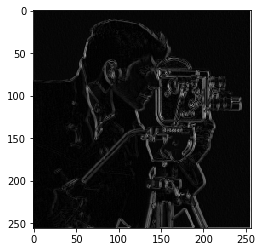

In [13]:
img = get_smple('./cman.jpg', True, True)

inp = np.array([img])
prediction = model.predict(inp)[0]
plt.imshow(prediction, cmap='gray')

## Understanding what's goind on...

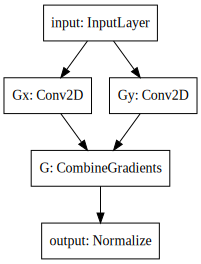

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
Gx = model.layers[1]
Gy = model.layers[2]

filterX = np.reshape(Gx.get_weights()[0], newshape=(3, 3))
filterY = np.reshape(Gy.get_weights()[0], newshape=(3, 3))
print('Filter in X direction:')
print(filterX)
print('\nFilter in Y direction')
print(filterY)

Filter in X direction:
[[-0.26965412  0.59984297  0.0251577 ]
 [-0.06543136 -0.28820831 -0.29859   ]
 [-0.3085236   0.27895501  0.33002526]]

Filter in Y direction
[[-0.06757317  0.42253894 -0.29630145]
 [-0.13084354  0.49114498 -0.44435886]
 [-0.35281268  0.37155992 -0.02089672]]
